In [27]:
import numpy as np
import os
import scipy
from scipy.stats import ttest_rel

In [47]:
def paired_ttests(A: np.ndarray,
                  B: np.ndarray,
                  alternative: str = "two-sided"):
    """
    Run paired t-tests between A and B for each of the two channels (axis=1),
    using only the first value in the last dimension (axis=2).

    Parameters
    ----------
    A, B : np.ndarray
        Arrays of shape (N, 2, 3), scores from two models on the same data.
    alternative : {"two-sided", "greater", "less"}
        Type of test:
          - "two-sided": H0 is mean(A - B) == 0
          - "greater":   H0 is mean(A - B) <= 0 (A not better than B)
          - "less":      H0 is mean(A - B) >= 0 (A not worse than B)

    Returns
    -------
    t_vals : np.ndarray
        Shape (2,), t-statistics for channels 0 and 1.
    p_vals : np.ndarray
        Shape (2,), adjusted p-values for chosen alternative.
    """
    if A.shape != B.shape:
        raise ValueError(f"Shape mismatch: A{A.shape} vs B{B.shape}")
    if A.ndim != 3 or A.shape[1] != 2 or A.shape[2] < 1:
        raise ValueError("Expected shape (N, 2, 3) with last dim >= 1.")

    # Take Recall
    met_index = 1
    print(f"Taking index: {met_index}")
    A_F1 = A[:, :, met_index]
    B_F1 = B[:, :, met_index]

    t_vals = np.empty(2, dtype=float)
    p_vals = np.empty(2, dtype=float)

    for j in range(2):
        a = A_F1[:, j]
        b = B_F1[:, j]

        t, p_two = ttest_rel(a, b)
        df = len(a) - 1

        if alternative == "two-sided":
            p_val = p_two
        elif alternative == "greater":   # H1: mean(a - b) > 0
            p_val = scipy.stats.t.sf(t, df)
        elif alternative == "less":      # H1: mean(a - b) < 0
            p_val = scipy.stats.t.cdf(t, df)
        else:
            raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")

        t_vals[j] = t
        p_vals[j] = p_val

    return t_vals, p_vals


# Aggregate batches
def load_batches_results(base_path, experiment_foldername, folders_name):
    corrs_all = []
    labels_all = []
    paths_all = []

    for folder_name in folders_name:
        folder_path = os.path.join(base_path, 'figures', experiment_foldername, 'attn_correlations', folder_name)

        corrs = np.load(os.path.join(folder_path, 'testset_soft_overlap_corrs.npy'))
        labels = np.load(os.path.join(folder_path, 'testset_soft_overlap_labels.npy'))
        paths = np.load(os.path.join(folder_path, 'testset_soft_overlap_paths.npy'))

        corrs_all.append(corrs)
        labels_all.extend(labels)
        paths_all.extend(paths)

    corrs_all = np.vstack(corrs_all)
    labels_all = np.asarray(labels_all)
    paths_all = np.asarray(paths_all)

    return corrs_all, labels_all, paths_all

def filter_by_overlapping_paths(corrs1, labels1, paths1, corrs2, labels2, paths2):
    # Find overlapping paths
    set_paths1 = set(paths1)
    set_paths2 = set(paths2)
    overlapping_paths = np.array(list(set_paths1.intersection(set_paths2)))

    # Filter corrs, labels, paths to only include overlapping paths
    mask1 = np.isin(paths1, overlapping_paths)
    mask2 = np.isin(paths2, overlapping_paths)

    corrs1_filtered = corrs1[mask1]
    labels1_filtered = labels1[mask1]
    paths1_filtered = paths1[mask1]

    corrs2_filtered = corrs2[mask2]
    labels2_filtered = labels2[mask2]
    paths2_filtered = paths2[mask2]

    return (corrs1_filtered, labels1_filtered, paths1_filtered,
            corrs2_filtered, labels2_filtered, paths2_filtered)

def align_corrs(corrs, labels, paths):
    # Sort by paths to ensure alignment
    sorted_indices = np.argsort(paths)
    corrs_sorted = corrs[sorted_indices]
    labels_sorted = labels[sorted_indices]
    paths_sorted = paths[sorted_indices]

    return corrs_sorted, labels_sorted, paths_sorted

def get_unique_markers(labels):
    markers = [label.split('_', 1)[0] for label in labels]
    return np.unique(markers)

def run_comparison(NOVA_model_path, pretrained_model_path, experiment_foldername, folders_name):
    print(f"experiment_foldername: {experiment_foldername}")

    nova_is_better_counter_nucleus, nova_is_better_counter_target = 0, 0

    nova_corrs, nova_labels, nova_paths = load_batches_results(NOVA_model_path, experiment_foldername, folders_name)
    print("NOVA:", nova_corrs.shape, nova_labels.shape, nova_paths.shape)

    pretrained_corrs, pretrained_labels, pretrained_paths = load_batches_results(pretrained_model_path, experiment_foldername, folders_name)
    print("Pretrained:", pretrained_corrs.shape, pretrained_labels.shape, pretrained_paths.shape)

    nova_corrs, nova_labels, nova_paths, pretrained_corrs, pretrained_labels, pretrained_paths = filter_by_overlapping_paths(nova_corrs, nova_labels, nova_paths,
                                                                                                                        pretrained_corrs, pretrained_labels, pretrained_paths)
    nova_corrs, nova_labels, nova_paths = align_corrs(nova_corrs, nova_labels, nova_paths)
    pretrained_corrs, pretrained_labels, pretrained_paths = align_corrs(pretrained_corrs, pretrained_labels, pretrained_paths)

    assert all(nova_paths == pretrained_paths), "Paths are not aligned after filtering and sorting."

    print(nova_corrs.shape, nova_labels.shape, nova_paths.shape)
    print(pretrained_corrs.shape, pretrained_labels.shape, pretrained_paths.shape)


    unique_markers = get_unique_markers(nova_labels)
    unique_markers = np.asarray([m for m in unique_markers if m != 'CD41'])
    print(f"Unique markers: ({len(unique_markers)})", unique_markers)

    for marker in unique_markers:
        n_idx = np.where(np.char.startswith(nova_labels, f"{marker}_"))[0]
        p_idx = np.where(np.char.startswith(pretrained_labels, f"{marker}_"))[0]

        n_l = nova_labels[n_idx]
        p_l = pretrained_labels[p_idx]

        n_path = nova_paths[n_idx]
        p_path = pretrained_paths[p_idx]

        n = nova_corrs[n_idx]
        p = pretrained_corrs[p_idx]

        t_stat, pval = paired_ttests(n, p, alternative='greater')
        print(f"Marker: {marker}, t-stat: {t_stat}, p-val: {pval}")

        if pval[0] <= 0.05: # We checked, 0 is the DAPI, 1 is the target (different from the image)
            nova_is_better_counter_nucleus += 1
        if pval[1] <= 0.05:
            nova_is_better_counter_target += 1


    nova_is_better_nucleus_per = nova_is_better_counter_nucleus * 100.0 / len(unique_markers)
    nova_is_better_target_per = nova_is_better_counter_target * 100.0 / len(unique_markers)
    print()
    print(f"NOVA > Pretrained (nucleus channel): {nova_is_better_nucleus_per}%")
    print(f"NOVA > Pretrained (target channel): {nova_is_better_target_per}%")

    return nova_is_better_nucleus_per, nova_is_better_target_per, len(nova_corrs), len(unique_markers)


In [48]:
NOVA_model_path = "/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/"
pretrained_model_path = "/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/pretrained_model/"

In [49]:
experiment_foldername = "NIH"
folders_name = ['batch1_all_reps_WT_Untreated_all_markers', 'batch2_all_reps_WT_Untreated_all_markers', 'batch3_all_reps_WT_Untreated_all_markers', 'batch1_all_reps_WT_stress_all_markers', 'batch2_all_reps_WT_stress_all_markers', 'batch3_all_reps_WT_stress_all_markers']
print(f"[{len(folders_name)}] {folders_name}")

nova_is_better_nucleus_per_NIH, nova_is_better_target_per_NIH, n_images_NIH, n_markers_NIH = run_comparison(NOVA_model_path, pretrained_model_path, experiment_foldername, folders_name)

[6] ['batch1_all_reps_WT_Untreated_all_markers', 'batch2_all_reps_WT_Untreated_all_markers', 'batch3_all_reps_WT_Untreated_all_markers', 'batch1_all_reps_WT_stress_all_markers', 'batch2_all_reps_WT_stress_all_markers', 'batch3_all_reps_WT_stress_all_markers']
experiment_foldername: NIH
NOVA: (598329, 2, 3) (598329,) (598329,)
Pretrained: (598329, 2, 3) (598329,) (598329,)
(598329, 2, 3) (598329,) (598329,)
(598329, 2, 3) (598329,) (598329,)
Unique markers: (26) ['ANAX11' 'CLTC' 'Calreticulin' 'DAPI' 'DCP1A' 'FMRP' 'FUS' 'G3BP1'
 'GM130' 'KIF5A' 'LAMP1' 'MitoTracker' 'NCL' 'NEMO' 'P54' 'PEX14' 'PML'
 'PSD95' 'PURA' 'Phalloidin' 'SNCA' 'SQSTM1' 'TDP43' 'TIA1' 'TOMM20'
 'TUJ1']
Taking index: 1
Marker: ANAX11, t-stat: [-4.95298171 -9.02034282], p-val: [0.99999963 1.        ]
Taking index: 1
Marker: CLTC, t-stat: [11.84849653 54.48392619], p-val: [1.58573798e-32 0.00000000e+00]
Taking index: 1
Marker: Calreticulin, t-stat: [21.48437588 14.9788501 ], p-val: [4.72270368e-101 1.24718610e-050]


In [50]:
experiment_foldername = "dNLS"
folders_name = os.listdir(os.path.join(NOVA_model_path, 'figures', experiment_foldername, 'attn_correlations'))
print(f"[{len(folders_name)}] {folders_name}")

nova_is_better_nucleus_per_dNLS, nova_is_better_target_per_dNLS, n_images_dNLS, n_markers_dNLS = run_comparison(NOVA_model_path, pretrained_model_path, experiment_foldername, folders_name)

[10] ['batch6_all_reps_dNLS_DOX_all_markers', 'batch6_all_reps_dNLS_Untreated_all_markers', 'batch1_all_reps_dNLS_Untreated_all_markers', 'batch4_all_reps_dNLS_Untreated_all_markers', 'batch5_all_reps_dNLS_Untreated_all_markers', 'batch4_all_reps_dNLS_DOX_all_markers', 'batch5_all_reps_dNLS_DOX_all_markers', 'batch2_all_reps_dNLS_DOX_all_markers', 'batch1_all_reps_dNLS_DOX_all_markers', 'batch2_all_reps_dNLS_Untreated_all_markers']
experiment_foldername: dNLS


NOVA: (1178762, 2, 3) (1178762,) (1178762,)
Pretrained: (1178762, 2, 3) (1178762,) (1178762,)
(1178762, 2, 3) (1178762,) (1178762,)
(1178762, 2, 3) (1178762,) (1178762,)
Unique markers: (29) ['ANXA11' 'CLTC' 'Calreticulin' 'DAPI' 'DCP1A' 'FMRP' 'FUS' 'G3BP1'
 'GM130' 'HNRNPA1' 'KIF5A' 'LAMP1' 'LSM14A' 'NCL' 'NEMO' 'NONO' 'PEX14'
 'PML' 'PSD95' 'PURA' 'Phalloidin' 'SNCA' 'SON' 'SQSTM1' 'TDP43' 'TIA1'
 'TOMM20' 'Tubulin' 'mitotracker']
Taking index: 1
Marker: ANXA11, t-stat: [-12.4205999   -7.92973151], p-val: [1. 1.]
Taking index: 1
Marker: CLTC, t-stat: [ 52.59964737 149.5058249 ], p-val: [0. 0.]
Taking index: 1
Marker: Calreticulin, t-stat: [ 56.69530741 102.18189694], p-val: [0. 0.]
Taking index: 1
Marker: DAPI, t-stat: [-291.06306815 -291.06306815], p-val: [1. 1.]
Taking index: 1
Marker: DCP1A, t-stat: [-123.01628082  -80.04778919], p-val: [1. 1.]
Taking index: 1
Marker: FMRP, t-stat: [19.33154341 30.0809685 ], p-val: [2.29765115e-082 2.78329757e-192]
Taking index: 1
Marker: FUS, t-

In [51]:
experiment_foldername = "AlyssaCoyne"
folders_name = os.listdir(os.path.join(NOVA_model_path, 'figures', experiment_foldername, 'attn_correlations'))
print(f"[{len(folders_name)}] {folders_name}")

nova_is_better_nucleus_per_AlyssaCoyne, nova_is_better_target_per_AlyssaCoyne, n_images_AlyssaCoyne, n_markers_AlyssaCoyne = run_comparison(NOVA_model_path, pretrained_model_path, experiment_foldername, folders_name)

[4] ['batch1_all_reps_sALSNegativeCytoTDP43_Untreated_without_MERGED', 'batch1_all_reps_Controls_Untreated_without_MERGED', 'batch1_all_reps_c9orf72ALSPatients_Untreated_without_MERGED', 'batch1_all_reps_sALSPositiveCytoTDP43_Untreated_without_MERGED']
experiment_foldername: AlyssaCoyne
NOVA: (9118, 2, 3) (9118,) (9118,)
Pretrained: (9118, 2, 3) (9118,) (9118,)
(9118, 2, 3) (9118,) (9118,)
(9118, 2, 3) (9118,) (9118,)
Unique markers: (4) ['DAPI' 'DCP1A' 'Map2' 'TDP43']
Taking index: 1
Marker: DAPI, t-stat: [-33.03053098 -33.03053098], p-val: [1. 1.]
Taking index: 1
Marker: DCP1A, t-stat: [-4.03921114  0.37661454], p-val: [0.9999723  0.35324754]
Taking index: 1
Marker: Map2, t-stat: [24.14016033  7.86436507], p-val: [3.66593063e-115 2.83643451e-015]
Taking index: 1
Marker: TDP43, t-stat: [-0.05181999  3.57372286], p-val: [5.20661659e-01 1.79633188e-04]

NOVA > Pretrained (nucleus channel): 25.0%
NOVA > Pretrained (target channel): 50.0%


In [52]:
experiment_foldername = "AlyssaCoyne_new"
folders_name = os.listdir(os.path.join(NOVA_model_path, 'figures', experiment_foldername, 'attn_correlations'))
print(f"[{len(folders_name)}] {folders_name}")

nova_is_better_nucleus_per_AlyssaCoyne_new, nova_is_better_target_per_AlyssaCoyne_new, n_images_AlyssaCoyne_new, n_markers_AlyssaCoyne_new = run_comparison(NOVA_model_path, pretrained_model_path, experiment_foldername, folders_name)

[12] ['batch1_all_reps_SALSNegative-CS0JPP_Untreated_without_TIA1', 'batch1_all_reps_C9-CS2YNL_Untreated_without_TIA1', 'batch1_all_reps_Ctrl-EDi037_Untreated_without_TIA1', 'batch1_all_reps_C9-CS8RFT_Untreated_without_TIA1', 'batch1_all_reps_SALSNegative-CS6ZU8_Untreated_without_TIA1', 'batch1_all_reps_SALSPositive-CS2FN3_Untreated_without_TIA1', 'batch1_all_reps_SALSPositive-CS4ZCD_Untreated_without_TIA1', 'batch1_all_reps_Ctrl-EDi022_Untreated_without_TIA1', 'batch1_all_reps_Ctrl-EDi029_Untreated_without_TIA1', 'batch1_all_reps_SALSNegative-CS0ANK_Untreated_without_TIA1', 'batch1_all_reps_C9-CS7VCZ_Untreated_without_TIA1', 'batch1_all_reps_SALSPositive-CS7TN6_Untreated_without_TIA1']
experiment_foldername: AlyssaCoyne_new
NOVA: (55443, 2, 3) (55443,) (55443,)
Pretrained: (55443, 2, 3) (55443,) (55443,)


(55443, 2, 3) (55443,) (55443,)
(55443, 2, 3) (55443,) (55443,)
Unique markers: (31) ['ANXA11' 'CLTC' 'Calnexin' 'Calreticulin' 'DAPI' 'DCP1A' 'EEA1' 'FMRP'
 'FUS' 'G3BP1' 'GM130' 'KIF5A' 'LaminB1' 'Lamp1' 'Map2' 'NCL' 'NEMO'
 'NONO' 'Nup153' 'Nup62' 'Nup98' 'POM121' 'PSD95' 'PURA' 'Phalloidin'
 'SCNA' 'SQSTM1' 'TDP43' 'TOMM20' 'hnRNPA1' 'hnRNPA2B1']
Taking index: 1
Marker: ANXA11, t-stat: [26.86664472 24.03549706], p-val: [1.88679444e-126 9.68301845e-106]
Taking index: 1
Marker: CLTC, t-stat: [39.07297069 21.28623797], p-val: [6.89700874e-224 3.72537181e-087]
Taking index: 1
Marker: Calnexin, t-stat: [23.91605588  7.86939757], p-val: [7.17563995e-105 3.80582941e-015]
Taking index: 1
Marker: Calreticulin, t-stat: [24.79160164 20.02604063], p-val: [2.72725897e-112 1.48929126e-078]
Taking index: 1
Marker: DAPI, t-stat: [-37.77389637 -37.77389637], p-val: [1. 1.]
Taking index: 1
Marker: DCP1A, t-stat: [-26.23620719 -14.44671729], p-val: [1. 1.]
Taking index: 1
Marker: EEA1, t-stat: [-21.7

# Plot results in a table

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def plot_results_table(results):
    """
    results: list of dicts, each with keys:
      - 'Dataset': str
      - 'perc_sig_markers': float (percentage, e.g. 72.5)
      - 'n_images': int
      - 'n_markers': int
    """
    df = pd.DataFrame(results)

    # Round percentages nicely
    df['perc_sig_markers_nucleus'] = df['perc_sig_markers_nucleus'].map(lambda x: f"{x:.2f}%")
    df['perc_sig_markers_target'] = df['perc_sig_markers_target'].map(lambda x: f"{x:.2f}%")
    

    display_labels = [
        "Dataset",
        "% Markers NOVA > Baseline (Significant) [nucleus channel]",
        "% Markers NOVA > Baseline (Significant) [target channel]",
        "# Images",
        "# Markers"
    ]

    fig, ax = plt.subplots(figsize=(6, 0.6*len(df)+1))
    ax.axis("off")

    table = ax.table(
        cellText=df.values,
        colLabels=display_labels,
        loc="center",
        cellLoc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(6)

    # Adjust specific column widths (col=0 is first column)
    for (row, col), cell in table.get_celld().items():
        if col >= 0 and row == 0:  # skip the actual header row
            cell.set_facecolor("#f0f0f0")  # light gray background
        if col == 0:
            cell.set_width(0.5)   # default ~0.2
        if col == 1:   # enlarge 2nd column
            cell.set_width(0.8)   # default ~0.2
        elif col == 2: # enlarge 3rd column
            cell.set_width(0.8)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_681124/2893299754.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


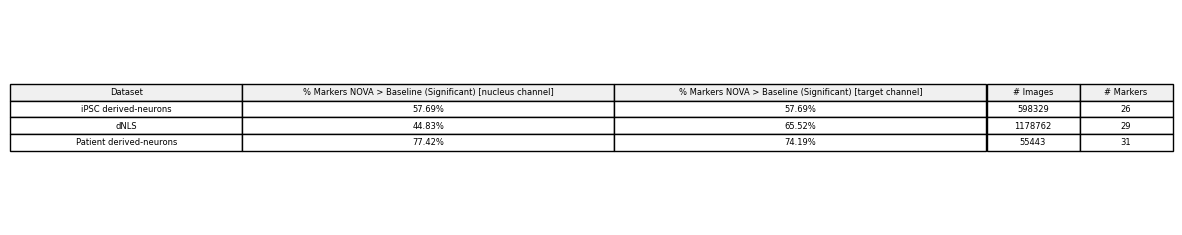

In [79]:
results = [
    {"Dataset": "iPSC derived-neurons", "perc_sig_markers_nucleus": nova_is_better_nucleus_per_NIH, "perc_sig_markers_target": nova_is_better_target_per_NIH, "n_images": n_images_NIH, "n_markers": n_markers_NIH},
    {"Dataset": "dNLS", "perc_sig_markers_nucleus": nova_is_better_nucleus_per_dNLS, "perc_sig_markers_target": nova_is_better_target_per_dNLS, "n_images": n_images_dNLS, "n_markers": n_markers_dNLS},
    {"Dataset": "Patient derived-neurons", "perc_sig_markers_nucleus": nova_is_better_nucleus_per_AlyssaCoyne_new, "perc_sig_markers_target": nova_is_better_target_per_AlyssaCoyne_new, "n_images": n_images_AlyssaCoyne_new, "n_markers": n_markers_AlyssaCoyne_new},
]

plot_results_table(results)

# Eval attention score

In [40]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

def load_corrs(root_folder: str):
    corrs = np.load(os.path.join(root_folder, "testset_soft_overlap_corrs.npy"))
    labels = np.load(os.path.join(root_folder, "testset_soft_overlap_labels.npy"))
    paths = np.load(os.path.join(root_folder, "testset_soft_overlap_paths.npy"))
    return corrs, labels, paths

def load_attn(root_folder: str):
    attn = np.load(os.path.join(root_folder, "testset.npy"))
    attn_labels = np.load(os.path.join(root_folder, "testset_labels.npy"))
    attn_paths = np.load(os.path.join(root_folder, "testset_paths.npy"))
    return attn, attn_labels, attn_paths

def get_attention_correlation_folder(model_folder:str, experiment_name:str, foldername:str):
    return os.path.join(model_folder, "figures", experiment_name, "attn_correlations", foldername)

def get_attention_folder(model_folder:str, experiment_name:str, foldername:str):
    return os.path.join(model_folder, "attention_maps", "processed", experiment_name, foldername)

def get_attention_map(attn, attn_path, image_path:str):
    print(attn_path[attn_path == image_path])
    return attn[attn_path == image_path]

def load_tile(path):
    image_path, tile_index = path.rsplit("/", 1)
    tile_index = int(tile_index)
    img = np.load(image_path)
    tile = img[tile_index]
    
    return tile  

def plot_image(image, path):
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(image[...,0], cmap='gray', vmin=0,vmax=1)
    ax[1].imshow(image[...,1], cmap='gray', vmin=0,vmax=1)

    ax[0].set_title("Target")
    ax[1].set_title("Nucleus")
    plt.suptitle(path)
    plt.show()

def create_attn_map_img(input_img, corr_data, attn_map, path, corr_data2, attn_map2):
    """
    Visualize attention alongside marker and nucleus channels in a 2x2 layout:

        [0,0] Marker channel       [0,1] Overlay (Input + Attn)
        [1,0] Nucleus channel      [1,1] Heatmap

    Args:
        attn_map: (H, W) attention map, scaled [0, 1]
        input_img: (H, W, 3) RGB image
        heatmap_colored: (H, W, 3) attention heatmap (BGR)
        config_plot: plotting config
        sup_title: overall title
        output_folder_path: optional path to save the figure

    Returns:
        fig: matplotlib figure object
    """

    alpha = 0.3
    figsize = (4,4)
    
    # Create figure with minimal spacing
    fig, ax = plt.subplots(2,2, figsize=figsize, 
                          gridspec_kw={'wspace': 0.02, 'hspace': 0.25})
    # Extract channels
    marker = input_img[..., 0]
    nucleus = input_img[..., 1]


    # [0,0] Marker channel
    ax[0,0].imshow(marker)
    ax[0,0].set_title("Marker (Green)", fontsize=6, pad=5)
    ax[0,0].set_axis_off()

    if corr_data is not None:
        corr_marker = corr_data[1]
        ax[0,0].text(
            0.5, -0.05,  # slightly below the axes
            corr_marker,
            transform=ax[0,0].transAxes,
            ha='center', va='top', fontsize=10, color='black'
        )

    # [1,0] Nucleus channel
    ax[0,1].imshow(nucleus)
    ax[0,1].set_title("Nucleus (Blue)", fontsize=6, pad=5)
    ax[0,1].set_axis_off()
    if corr_data is not None:
        corr_nucleus = corr_data[0]
        ax[0,1].text(
            0.5, -0.05,  # slightly below the axes
            corr_nucleus,
            transform=ax[0,1].transAxes,
            ha='center', va='top', fontsize=10, color='black'
        )

    # Contour fill & lines for attention overlay
    fill_cmap = LinearSegmentedColormap.from_list(
        'fill_colors',
        [(0, 0, 0, 0),
         (1, 1, 0, 0.4),
         (1, 0.6, 0, 0.6),
         (1, 0, 0, 0.8)]
    )
    line_cmap = LinearSegmentedColormap.from_list(
        'line_colors',
        [(1, 1, 1, 0.2),
         (1, 1, 0, 0.4),
         (1, 0.6, 0, 0.6),
         (1, 0, 0, 0.8)]
    )
    levels = np.linspace(0.3, 1.0, 10)

    ax[0,0].contourf(attn_map, levels=levels, cmap=fill_cmap, alpha=alpha)
    ax[0,0].contour(attn_map, levels=levels, cmap=line_cmap, linewidths=1.0, alpha=alpha + 0.05)
    ax[0,0].set_axis_off()

    ax[0,1].contourf(attn_map, levels=levels, cmap=fill_cmap, alpha=alpha)
    ax[0,1].contour(attn_map, levels=levels, cmap=line_cmap, linewidths=1.0, alpha=alpha + 0.05)
    ax[0,1].set_axis_off()


    ##
    
    # [0,0] Marker channel
    ax[1,0].imshow(marker)
    ax[1,0].set_title("Marker (Green)", fontsize=6, pad=5)
    ax[1,0].set_axis_off()

    if corr_data2 is not None:
        corr_marker = corr_data2[1]
        ax[1,0].text(
            0.5, -0.05,  # slightly below the axes
            corr_marker,
            transform=ax[1,0].transAxes,
            ha='center', va='top', fontsize=10, color='black'
        )

    # [1,0] Nucleus channel
    ax[1,1].imshow(nucleus)
    ax[1,1].set_title("Nucleus (Blue)", fontsize=6, pad=5)
    ax[1,1].set_axis_off()
    if corr_data2 is not None:
        corr_nucleus = corr_data2[0]
        ax[1,1].text(
            0.5, -0.05,  # slightly below the axes
            corr_nucleus,
            transform=ax[1,1].transAxes,
            ha='center', va='top', fontsize=10, color='black'
        )

    # Contour fill & lines for attention overlay
    fill_cmap = LinearSegmentedColormap.from_list(
        'fill_colors',
        [(0, 0, 0, 0),
         (1, 1, 0, 0.4),
         (1, 0.6, 0, 0.6),
         (1, 0, 0, 0.8)]
    )
    line_cmap = LinearSegmentedColormap.from_list(
        'line_colors',
        [(1, 1, 1, 0.2),
         (1, 1, 0, 0.4),
         (1, 0.6, 0, 0.6),
         (1, 0, 0, 0.8)]
    )
    levels = np.linspace(0.3, 1.0, 10)

    ax[1,0].contourf(attn_map2, levels=levels, cmap=fill_cmap, alpha=alpha)
    ax[1,0].contour(attn_map2, levels=levels, cmap=line_cmap, linewidths=1.0, alpha=alpha + 0.05)
    ax[1,0].set_axis_off()

    ax[1,1].contourf(attn_map2, levels=levels, cmap=fill_cmap, alpha=alpha)
    ax[1,1].contour(attn_map2, levels=levels, cmap=line_cmap, linewidths=1.0, alpha=alpha + 0.05)
    ax[1,1].set_axis_off()


    # Add main title with proper spacing
    fig.suptitle(path, fontsize=6, y=0.95)

    # Fine-tune the layout
    plt.subplots_adjust(top=0.88, bottom=0.02, left=0.02, right=0.98)

    plt.show()


In [44]:
# experiment_name = "NIH"
# attn_folder_name = "batch1"
# atttn_correlation_folder_name = "batch1_all_reps_WT_Untreated_all_markers"

experiment_name = "AlyssaCoyne_new"
attn_folder_name = "batch1"
atttn_correlation_folder_name = "batch1_all_reps_Ctrl-EDi029_Untreated_without_TIA1"

NOVA (55443, 100, 100) (55443,) (55443,)
Pretrained (55443, 100, 100) (55443,) (55443,)
NOVA corrs (4328, 2, 3) (4328,) (4328,)
Pretrained corrs (4328, 2, 3) (4328,) (4328,)
Plot 20 examples
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/TDP43/rep1_control EDi029_DAPI_DCP1A_Map2_TDP-43_3-Orthogonal Projection-86-Image Export-23_c1_s23_panelA_Ctrl-EDi029_processed.npy/2']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/TDP43/rep1_control EDi029_DAPI_DCP1A_Map2_TDP-43_3-Orthogonal Projection-86-Image Export-23_c1_s23_panelA_Ctrl-EDi029_processed.npy/2']


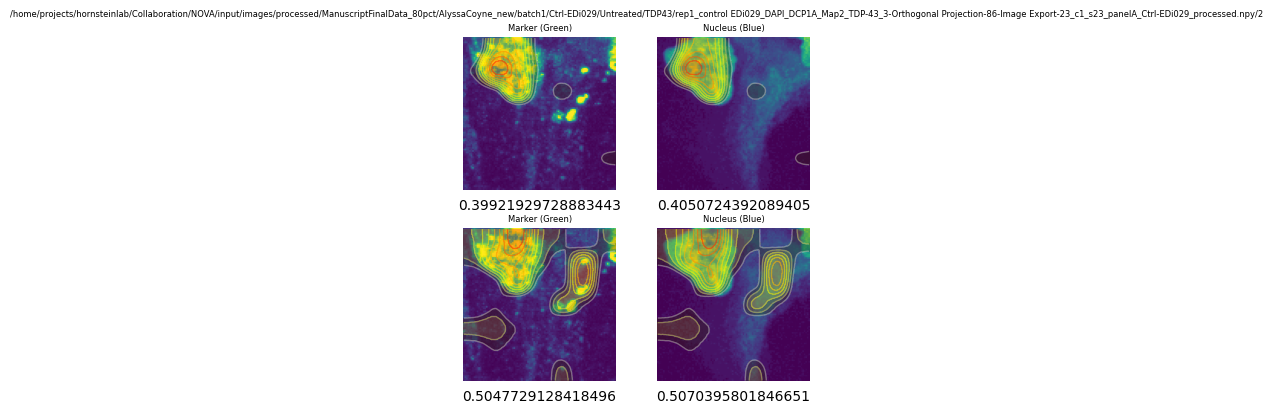

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/LaminB1/rep1_control EDi029_DAPI_POM121_Nup62_Lamin B1_2-Orthogonal Projection-34-Image Export-22_c1_s22_panelB_Ctrl-EDi029_processed.npy/14']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/LaminB1/rep1_control EDi029_DAPI_POM121_Nup62_Lamin B1_2-Orthogonal Projection-34-Image Export-22_c1_s22_panelB_Ctrl-EDi029_processed.npy/14']


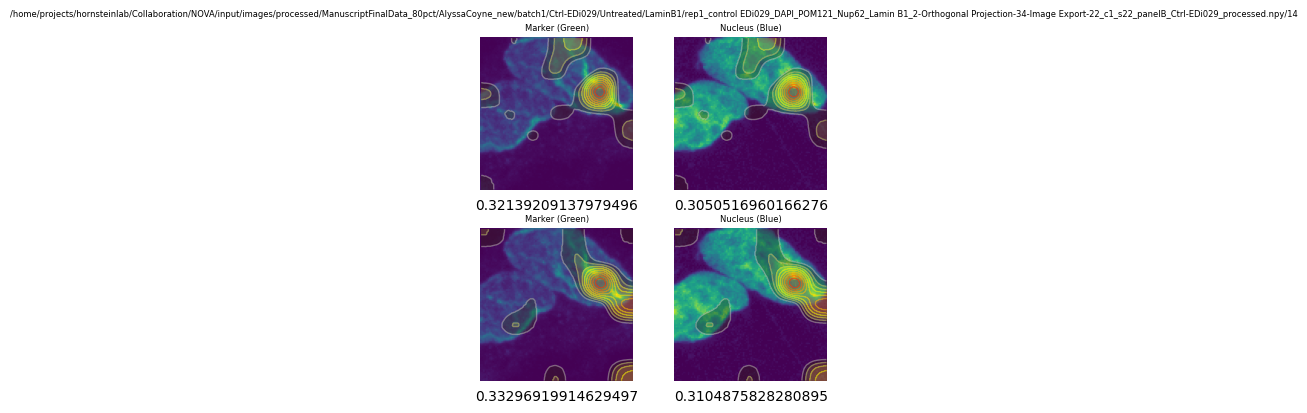

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/hnRNPA1/rep2_control EDi029_DAPI_EEA1_XXXXX_hnRNP A1_6-Orthogonal Projection-56-Image Export-16_c1_s16_panelK_Ctrl-EDi029_processed.npy/4']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/hnRNPA1/rep2_control EDi029_DAPI_EEA1_XXXXX_hnRNP A1_6-Orthogonal Projection-56-Image Export-16_c1_s16_panelK_Ctrl-EDi029_processed.npy/4']


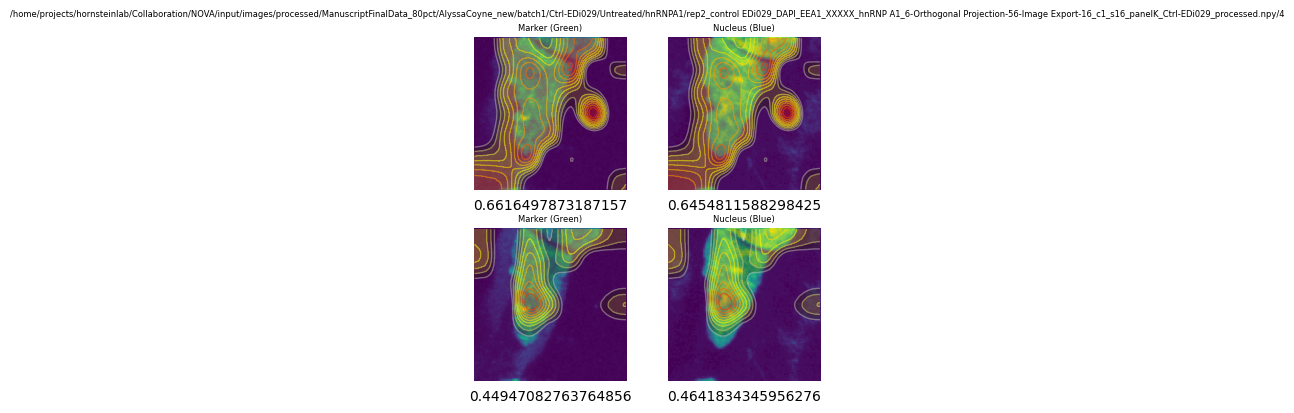

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/EEA1/rep1_control EDi029_DAPI_EEA1_XXXXX_hnRNP A1_5-Orthogonal Projection-54-Image Export-15_c2_s15_panelK_Ctrl-EDi029_processed.npy/11']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/EEA1/rep1_control EDi029_DAPI_EEA1_XXXXX_hnRNP A1_5-Orthogonal Projection-54-Image Export-15_c2_s15_panelK_Ctrl-EDi029_processed.npy/11']


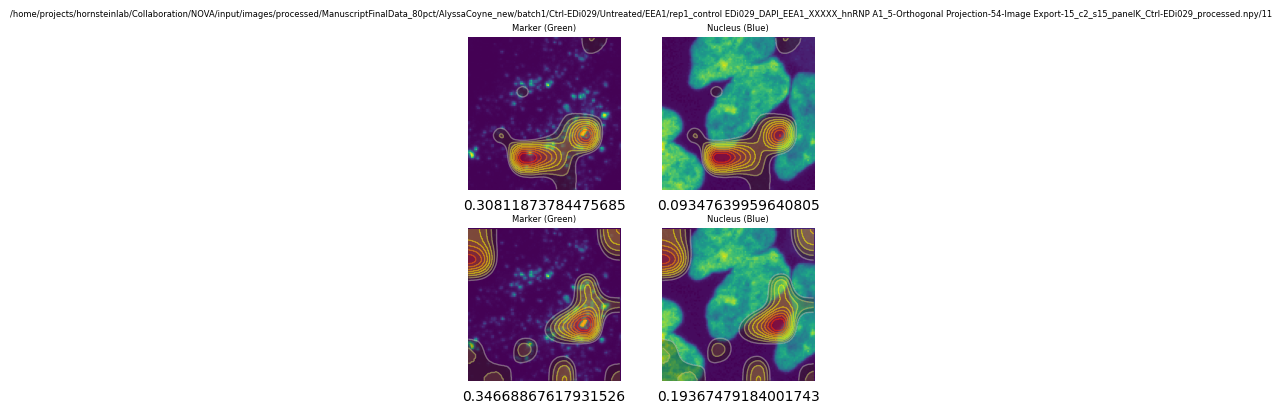

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/CLTC/rep2_control EDi029_DAPI_CLTC_XXXXX_NONO_9-Orthogonal Projection-91-Image Export-19_c2_s19_panelJ_Ctrl-EDi029_processed.npy/3']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/CLTC/rep2_control EDi029_DAPI_CLTC_XXXXX_NONO_9-Orthogonal Projection-91-Image Export-19_c2_s19_panelJ_Ctrl-EDi029_processed.npy/3']


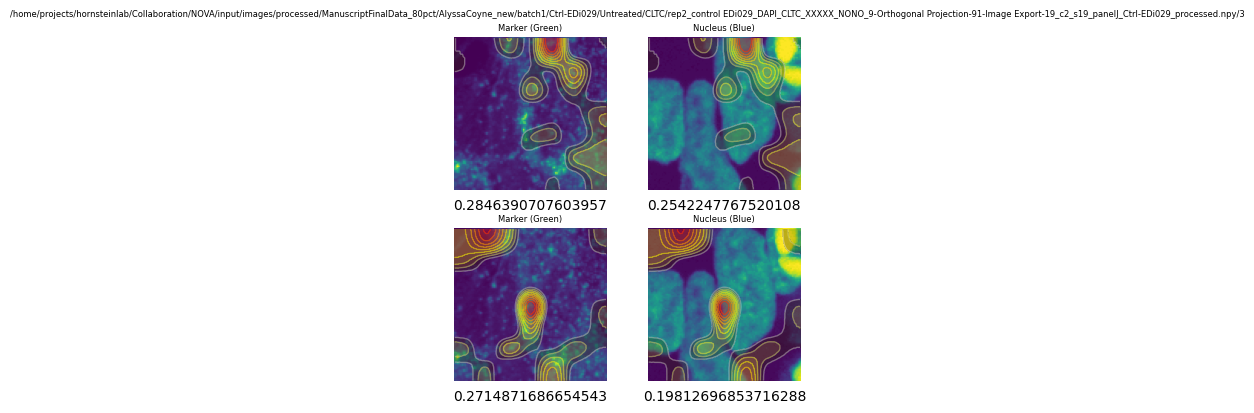

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/TOMM20/rep1_control EDi029_DAPI_TOMM20_Nup98_TIA1_4-Orthogonal Projection-60-Image Export-24_c3_s24_panelE_Ctrl-EDi029_processed.npy/3']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/TOMM20/rep1_control EDi029_DAPI_TOMM20_Nup98_TIA1_4-Orthogonal Projection-60-Image Export-24_c3_s24_panelE_Ctrl-EDi029_processed.npy/3']


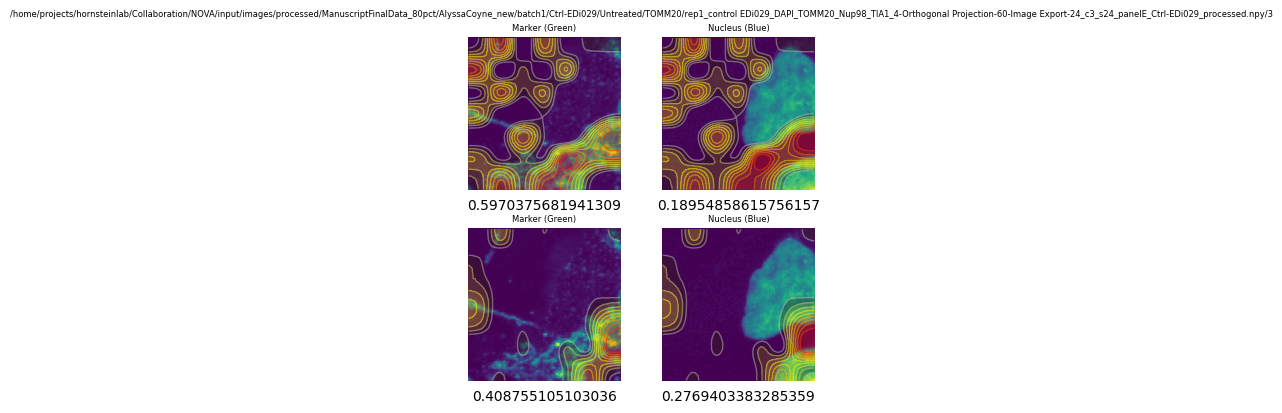

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/Map2/rep2_control EDi029_DAPI_DCP1A_Map2_TDP-43_7-Orthogonal Projection-94-Image Export-27_c2_s27_panelA_Ctrl-EDi029_processed.npy/7']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/Map2/rep2_control EDi029_DAPI_DCP1A_Map2_TDP-43_7-Orthogonal Projection-94-Image Export-27_c2_s27_panelA_Ctrl-EDi029_processed.npy/7']


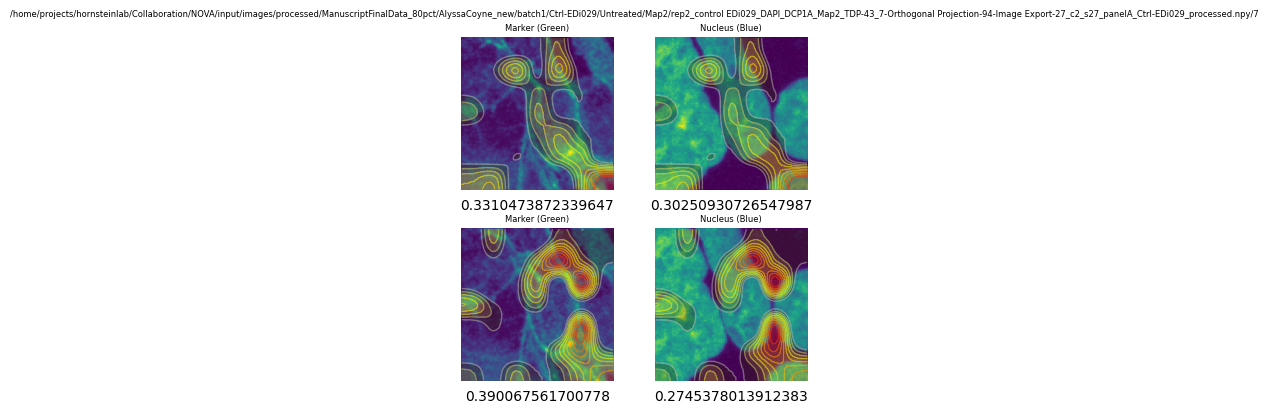

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/TDP43/rep1_control EDi029_DAPI_DCP1A_Map2_TDP-43_4-Orthogonal Projection-88-Image Export-24_c1_s24_panelA_Ctrl-EDi029_processed.npy/13']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/TDP43/rep1_control EDi029_DAPI_DCP1A_Map2_TDP-43_4-Orthogonal Projection-88-Image Export-24_c1_s24_panelA_Ctrl-EDi029_processed.npy/13']


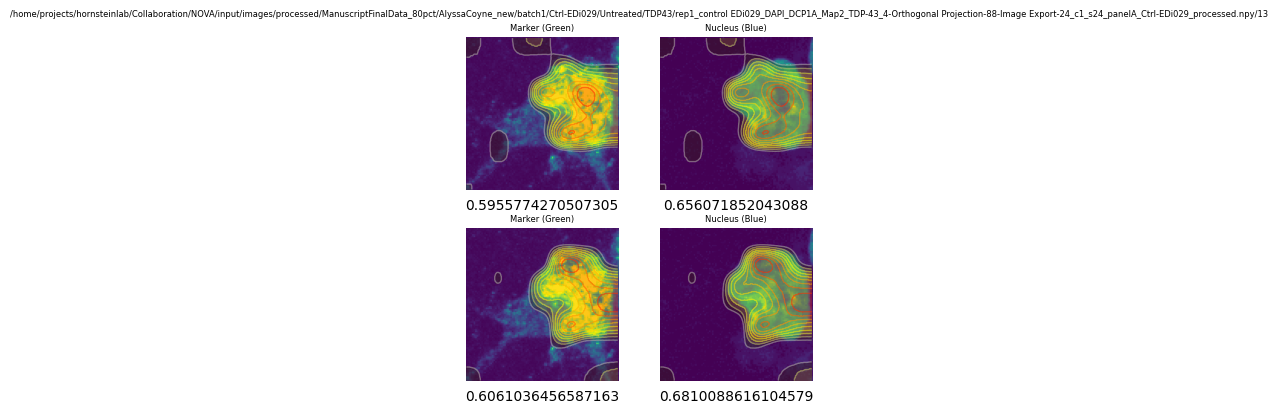

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/CLTC/rep1_control EDi029_DAPI_CLTC_XXXXX_NONO_3-Orthogonal Projection-79-Image Export-13_c2_s13_panelJ_Ctrl-EDi029_processed.npy/6']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/CLTC/rep1_control EDi029_DAPI_CLTC_XXXXX_NONO_3-Orthogonal Projection-79-Image Export-13_c2_s13_panelJ_Ctrl-EDi029_processed.npy/6']


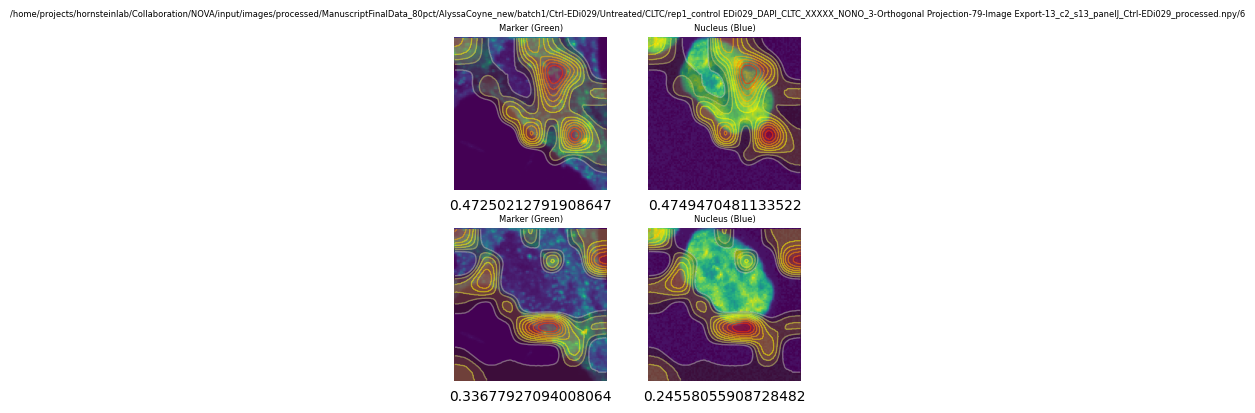

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/SQSTM1/rep1_control EDi029_DAPI_Lamp1_PSD95_SQSTM1_1-Orthogonal Projection-88-Image Export-11_c1_s11_panelG_Ctrl-EDi029_processed.npy/3']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/SQSTM1/rep1_control EDi029_DAPI_Lamp1_PSD95_SQSTM1_1-Orthogonal Projection-88-Image Export-11_c1_s11_panelG_Ctrl-EDi029_processed.npy/3']


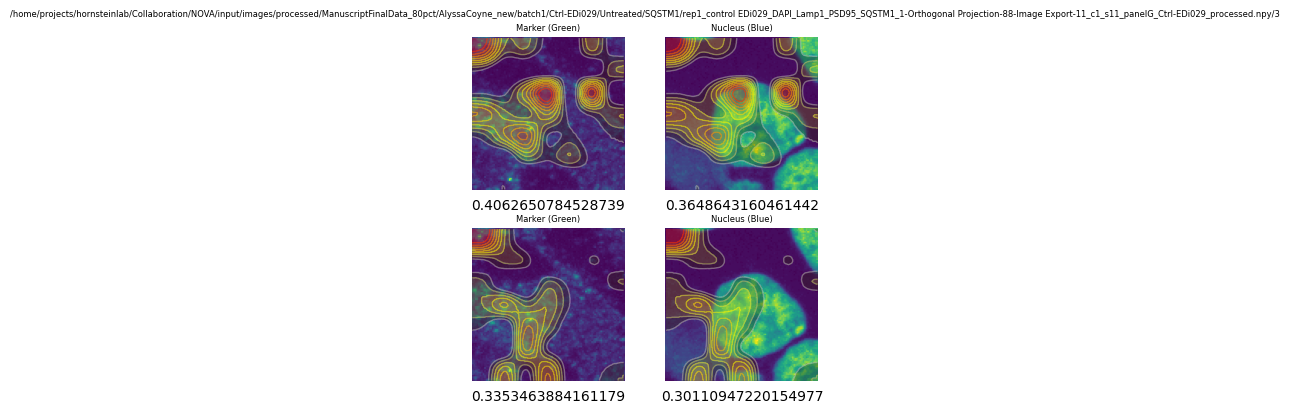

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/TOMM20/rep2_control EDi029_DAPI_TOMM20_Nup98_TIA1_9-Orthogonal Projection-70-Image Export-29_c3_s29_panelE_Ctrl-EDi029_processed.npy/13']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/TOMM20/rep2_control EDi029_DAPI_TOMM20_Nup98_TIA1_9-Orthogonal Projection-70-Image Export-29_c3_s29_panelE_Ctrl-EDi029_processed.npy/13']


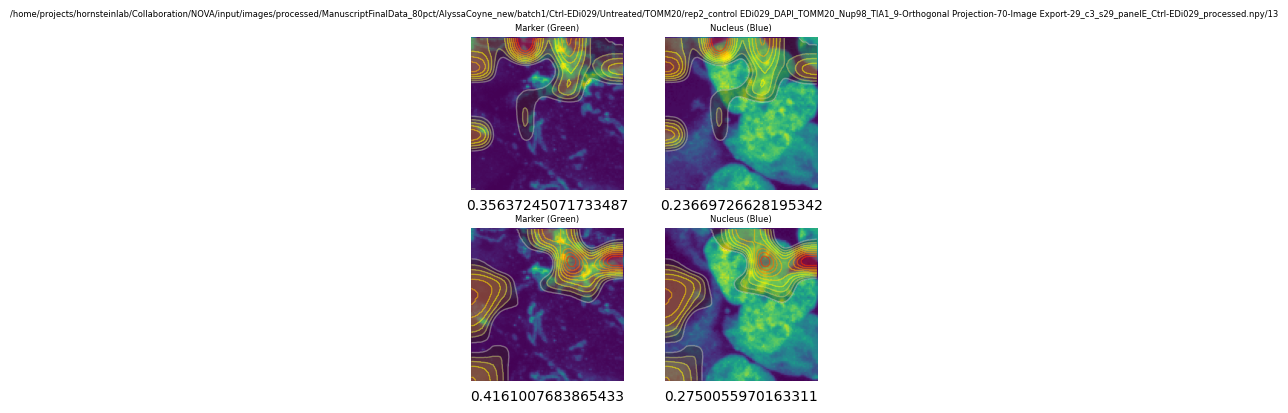

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/G3BP1/rep2_control EDi029_DAPI_KIF5A_PURA_G2BP1_7-Orthogonal Projection-16-Image Export-27_c1_s27_panelC_Ctrl-EDi029_processed.npy/5']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/G3BP1/rep2_control EDi029_DAPI_KIF5A_PURA_G2BP1_7-Orthogonal Projection-16-Image Export-27_c1_s27_panelC_Ctrl-EDi029_processed.npy/5']


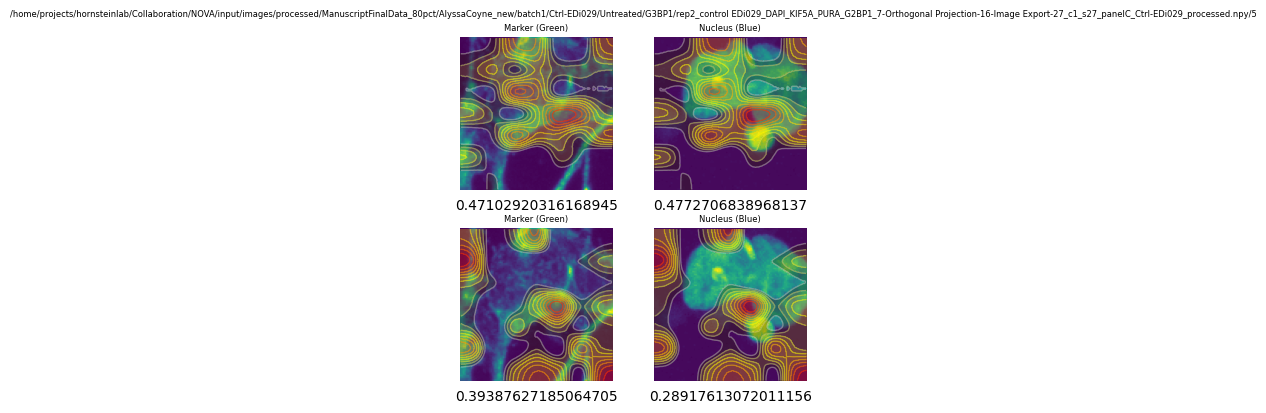

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/TDP43/rep2_control EDi029_DAPI_DCP1A_Map2_TDP-43_6-Orthogonal Projection-92-Image Export-26_c1_s26_panelA_Ctrl-EDi029_processed.npy/0']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/TDP43/rep2_control EDi029_DAPI_DCP1A_Map2_TDP-43_6-Orthogonal Projection-92-Image Export-26_c1_s26_panelA_Ctrl-EDi029_processed.npy/0']


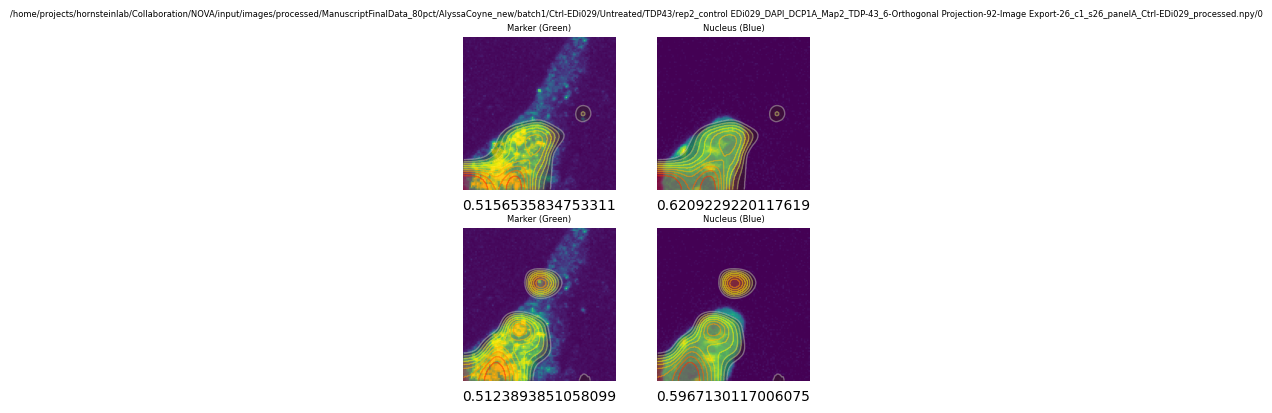

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/TOMM20/rep1_control EDi029_DAPI_TOMM20_Nup98_TIA1_2-Orthogonal Projection-56-Image Export-22_c3_s22_panelE_Ctrl-EDi029_processed.npy/1']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/TOMM20/rep1_control EDi029_DAPI_TOMM20_Nup98_TIA1_2-Orthogonal Projection-56-Image Export-22_c3_s22_panelE_Ctrl-EDi029_processed.npy/1']


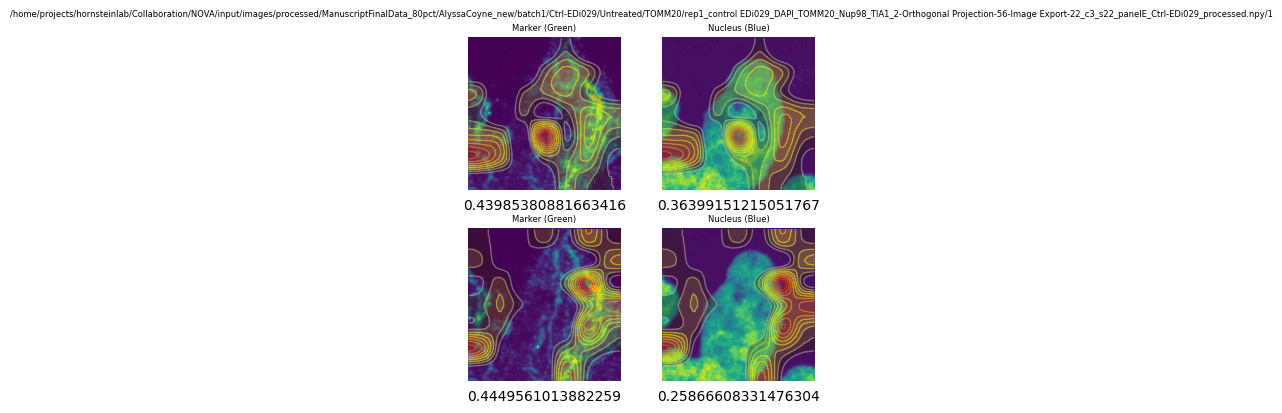

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/PURA/rep2_control EDi029_DAPI_KIF5A_PURA_G2BP1_9-Orthogonal Projection-20-Image Export-29_c2_s29_panelC_Ctrl-EDi029_processed.npy/2']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/PURA/rep2_control EDi029_DAPI_KIF5A_PURA_G2BP1_9-Orthogonal Projection-20-Image Export-29_c2_s29_panelC_Ctrl-EDi029_processed.npy/2']


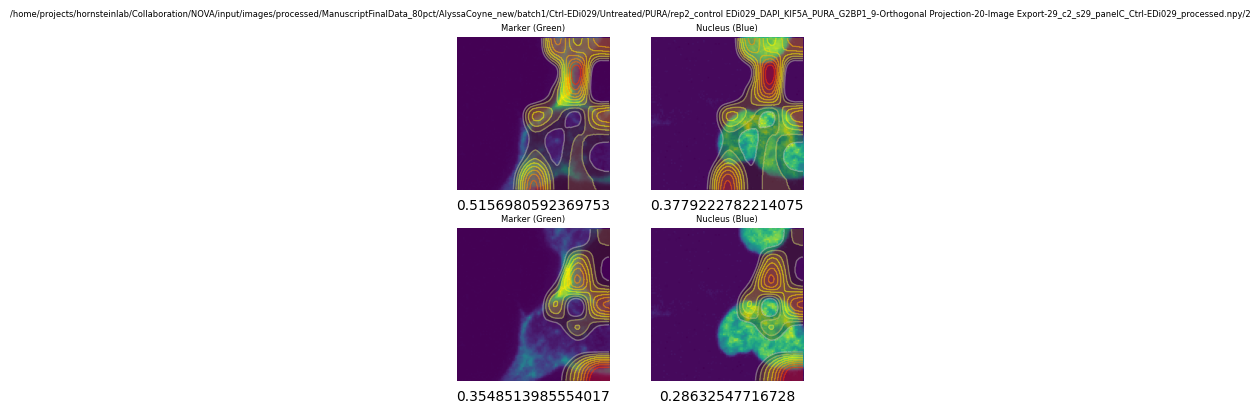

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/LaminB1/rep1_control EDi029_DAPI_POM121_Nup62_Lamin B1_1-Orthogonal Projection-31-Image Export-21_c1_s21_panelB_Ctrl-EDi029_processed.npy/8']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/LaminB1/rep1_control EDi029_DAPI_POM121_Nup62_Lamin B1_1-Orthogonal Projection-31-Image Export-21_c1_s21_panelB_Ctrl-EDi029_processed.npy/8']


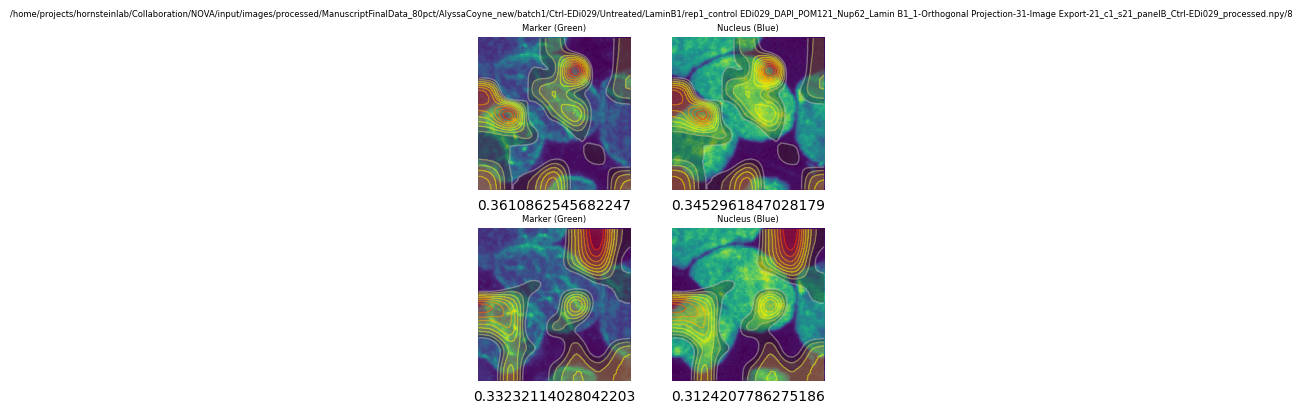

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/LaminB1/rep2_control EDi029_DAPI_POM121_Nup62_Lamin B1_7-Orthogonal Projection-44-Image Export-27_c1_s27_panelB_Ctrl-EDi029_processed.npy/5']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/LaminB1/rep2_control EDi029_DAPI_POM121_Nup62_Lamin B1_7-Orthogonal Projection-44-Image Export-27_c1_s27_panelB_Ctrl-EDi029_processed.npy/5']


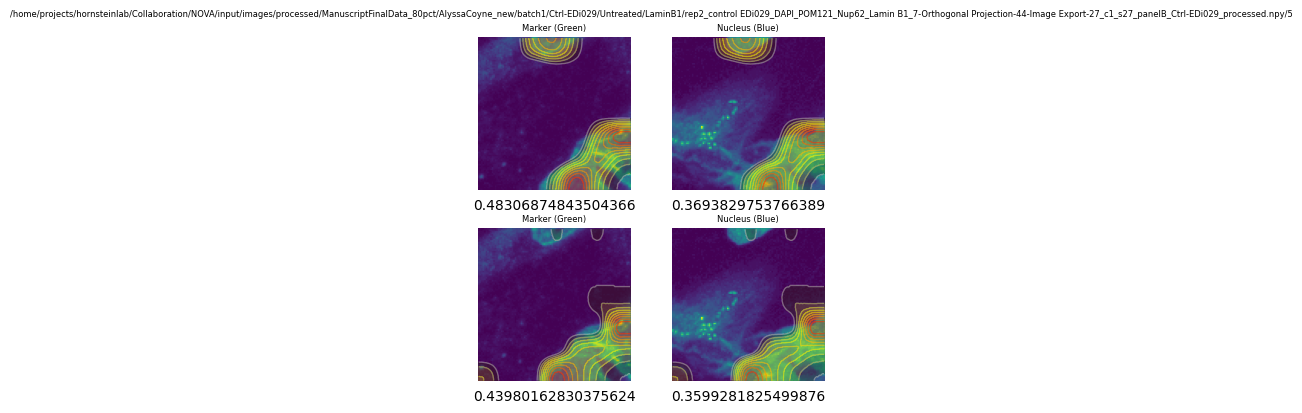

['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/hnRNPA2B1/rep1_control EDi029_DAPI_Calnexin_XXXXX_hnRNP A2B1_4-Orthogonal Projection-134-Image Export-14_c1_s14_panelL_Ctrl-EDi029_processed.npy/8']
['/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new/batch1/Ctrl-EDi029/Untreated/hnRNPA2B1/rep1_control EDi029_DAPI_Calnexin_XXXXX_hnRNP A2B1_4-Orthogonal Projection-134-Image Export-14_c1_s14_panelL_Ctrl-EDi029_processed.npy/8']


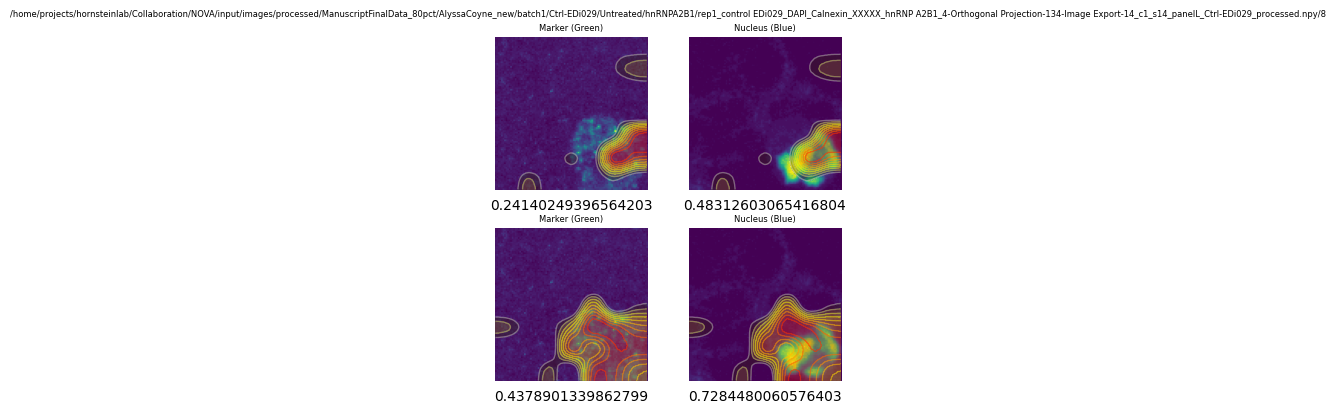

In [45]:
nova_attn_folder_path = get_attention_folder(NOVA_model_path, experiment_name, attn_folder_name)
nova_attn, nova_attn_labels, nova_attn_paths = load_attn(nova_attn_folder_path)
print("NOVA", nova_attn.shape, nova_attn_labels.shape, nova_attn_paths.shape)

pretrained_attn_folder_path = get_attention_folder(pretrained_model_path, experiment_name, attn_folder_name)
pretrained_attn, pretrained_attn_labels, pretrained_attn_paths = load_attn(pretrained_attn_folder_path)
print("Pretrained", pretrained_attn.shape, pretrained_attn_labels.shape, pretrained_attn_paths.shape)

nova_folder_path = get_attention_correlation_folder(NOVA_model_path, experiment_name, atttn_correlation_folder_name)

nova_corrs, nova_labels, nova_paths = load_corrs(nova_folder_path)
print("NOVA corrs", nova_corrs.shape, nova_labels.shape, nova_paths.shape)

pretrained_folder_path = get_attention_correlation_folder(pretrained_model_path, experiment_name, atttn_correlation_folder_name)

pretrained_corrs, pretrained_labels, pretrained_paths = load_corrs(pretrained_folder_path)
print("Pretrained corrs", pretrained_corrs.shape, pretrained_labels.shape, pretrained_paths.shape)

n = 20
print(f"Plot {n} examples")
indexes = np.random.choice(np.arange(len(nova_paths)), size=n, replace=False)
for i in indexes:
    if "/DAPI/" in nova_paths[i] or "/CD41/" in nova_paths[i]:
        continue
    
    path = nova_paths[i]
    tile = load_tile(path)

    nova_corr = nova_corrs[i,:,1] # 1 stands for the RECALL metric
    nova_attn_map = get_attention_map(nova_attn, nova_attn_paths, path)[0]

    pretrained_indx = np.where(pretrained_paths == path)[0][0]
    pretrained_corr = pretrained_corrs[pretrained_indx,:,1] # 1 stands for the RECALL metric
    pretrained_attn_map = get_attention_map(pretrained_attn, pretrained_attn_paths, path)[0]
    
    create_attn_map_img(tile, nova_corr, nova_attn_map, path, pretrained_corr, pretrained_attn_map)